In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import tailer
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
rank_perc = [950, 990, 995]
#factors = ["BHLHE40", "CEBPB", "CTCF", "E2F4", "EBF1", "ELF1", "ELK1", "ETS1", "FOS", "IRF4", "JunD", "Max", "MEF2A", "MEF2C", "Mxi1", "NFIC", "NFKB", "NFYA", "NFYB", "Nrf1", "NRSF", "PAX5", "PBX3", "POU2F2", "PU1", "RFX5", "RUNX3", "SP1", "SRF", "STAT1", "STAT3", "TCF3", "USF1", "USF2", "YY1", "ZBTB33", "ZEB1", "Znf143"]
factors = ["SP1", "EBF1", "PU1", "RUNX3", "NFYB", "Nrf1", "ELF1", "NFKB", "Znf143", "TCF3"]
factordata = {}
DIR="/storage/pandaman/project/singletons/AgentBind/"
for f in factors:
    # load data
    fdata = pd.read_csv(os.path.join(DIR, f, "scores.tab"), sep="\t", skiprows=1,
                            names=["chrom","start","raw.score","snr.score","rank","core"])
    fdata = fdata[~np.isnan(fdata["raw.score"])]
    fdata = fdata[~np.isnan(fdata["snr.score"])]
    fdata["factor"] = f
    factordata[f] = fdata
    print (f)

SP1
EBF1
PU1
RUNX3
NFYB
Nrf1
ELF1
NFKB
Znf143
TCF3


In [3]:
gwas = pd.read_csv("/storage/pandaman/project/GWAS/wbc_N172435_narrow_form.tsv.gz", sep="\t")
gwas["CHR"] = gwas["CHR"].apply(lambda x: "chr"+str(x))
gwas["BP"] = gwas["BP"].apply(lambda x: x-1)
gwas = gwas.rename(columns={"CHR": "chrom", "BP": "start"})

In [4]:
gwd = {}
for f in factors:
    fd = factordata[f]
    fd["chrom"] = fd["chrom"].apply(str)
    merged_df = pd.merge(fd, gwas, on=["chrom","start"])
    merged_df = merged_df[((merged_df["REF"]).str.len() == 1) & ((merged_df["ALT"]).str.len() == 1)]
    merged_df = merged_df.sort_values("rank", ascending=False)
    merged_df = merged_df.drop_duplicates(subset=["chrom", "start"], keep='first')
    gwd[f] = merged_df

In [5]:
bins = [0, 0.00025, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5]

In [6]:
gwd["SP1"].head()

,chrom,start,raw.score,snr.score,rank,core,factor,VARIANT,ID_dbSNP49,REF,ALT,ALT_MINOR,DIRECTION,EFFECT,SE,P,MLOG10P,ALT_FREQ,MA_FREQ
138112,chr1,67807901,0.000807,24.352987,1000.0,0,SP1,1:67807902_T_G,rs549327748,T,G,True,-,-0.022784,0.070456,0.7464,0.127026,0.0010,0.0010
69850,chr7,73668272,0.000041,20.415581,1000.0,0,SP1,7:73668273_T_C,rs3135655,T,C,True,-,-0.002833,0.004425,0.5220,0.282350,0.2387,0.2387
151657,chr11,85956263,0.000152,14.662241,1000.0,1,SP1,11:85956264_G_A,rs537997258,G,A,True,+,0.150938,0.137610,0.2727,0.564303,0.0003,0.0003
266354,chr10,99894341,0.000026,15.410391,1000.0,0,SP1,10:99894342_C_T,rs756610059,C,T,True,-,-0.075563,0.151617,0.6182,0.208861,0.0003,0.0003
4442,chr1,227015885,0.000125,32.030363,1000.0,0,SP1,1:227015886_G_C,rs538826703,G,C,True,+,0.115273,0.125001,0.3564,0.448020,0.0005,0.0005


9409 1530 9085
2016 1530 1941
1130 1530 1091


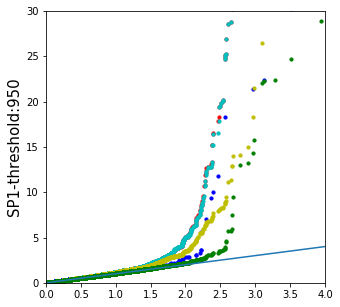

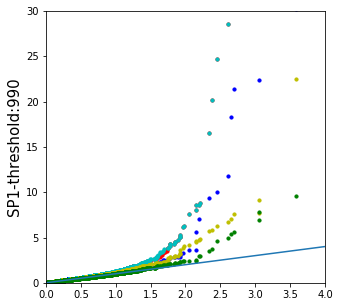

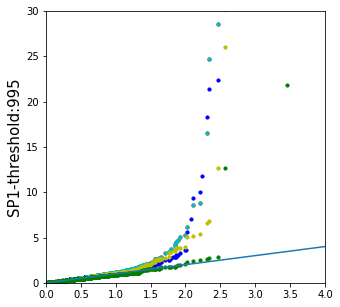

In [7]:
import random
from math import log10

for f in factors:
    if f != "SP1":
        continue
    for perc_index in range(len(rank_perc)):
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]
        core = gwd[f][gwd[f]["core"] == 1]
        noncore = high_scored_ab[high_scored_ab["core"] == 0]
        print (high_scored_ab.shape[0], core.shape[0], noncore.shape[0])
        # control - same MA_FREA distribution
        dist, _ = numpy.histogram(high_scored_ab["MA_FREQ"].tolist(), bins=bins)
        control_list = []
        control_list_all = []
        for bin_index in range(len(bins)-1):
            lower, upper = bins[bin_index], bins[bin_index + 1]
            n_samples = dist[bin_index]
            control_list.append((gwd[f][(gwd[f]["MA_FREQ"] >= lower) & (gwd[f]["MA_FREQ"] < upper)]).sample(n_samples))
            control_list_all.append((gwas[(gwas["MA_FREQ"] >= lower) & (gwas["MA_FREQ"] < upper)]).sample(n_samples))
        control = pd.concat(control_list)
        control_all = pd.concat(control_list_all)
                
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        s_core = core["MLOG10P"]
        s_noncore = noncore["MLOG10P"]
        s_ct = control["MLOG10P"]
        s_ct_all = control_all["MLOG10P"]

        
        s_random = [-log10(random.random()) for _ in range(max(high_scored_ab.shape[0], core.shape[0]))]
        s_random_ab = s_random[:high_scored_ab.shape[0]]
        s_random_core = s_random[:core.shape[0]]
        s_random_noncore = s_random[:noncore.shape[0]]
        
        y_points_ab = sorted(s_high_scored_ab.values.tolist())
        y_points_core = sorted(s_core.values.tolist())
        y_points_ct = sorted(s_ct.values.tolist())
        y_points_noncore = sorted(s_noncore.values.tolist())
        y_points_ct_all = sorted(s_ct_all.values.tolist())
        x_points_ab = sorted(s_random_ab)
        x_points_core = sorted(s_random_core)
        x_points_noncore = sorted(s_random_noncore)
        
        fig = plt.figure()
        fig.set_size_inches((5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(x_points_ab, y_points_ab, c="r", s=10)
        ax.scatter(x_points_core, y_points_core, c="b", s=10)
        ax.scatter(x_points_noncore, y_points_noncore, c="c", s=10)
        ax.scatter(x_points_ab, y_points_ct, c="y", s=10)
        ax.scatter(x_points_ab, y_points_ct_all, c="g", s=10)
        ax.set_ylabel("%s-threshold:%d" %(f, rank_perc[perc_index]), size=15)
        ((xmin,xmax), (ymin,ymax)) = ((0, 4), (0, 30))
        ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])

In [8]:
results = gwd["SP1"][gwd["SP1"]["rank"] >= rank_perc[0]]
results = results.sort_values("MLOG10P", ascending=False)
with open("/storage/pandaman/project/GWAS/high_scored.csv", 'w') as ofile:
    ofile.write(results.to_csv(index=False))

In [9]:
results

,chrom,start,raw.score,snr.score,rank,core,factor,VARIANT,ID_dbSNP49,REF,ALT,ALT_MINOR,DIRECTION,EFFECT,SE,P,MLOG10P,ALT_FREQ,MA_FREQ
67348,chr6,31705863,0.000538,17.163938,989.0,0,SP1,6:31705864_C_T,rs3101018,C,T,True,-,-0.107821,0.005278,9.350000e-93,92.029350,0.1322,0.1322
113741,chr6,31276199,0.000332,3.834302,956.0,0,SP1,6:31276200_C_T,rs1634758,C,T,True,+,0.092371,0.004986,1.232000e-76,75.909310,0.1535,0.1535
113722,chr6,31276041,0.000869,7.852933,992.0,0,SP1,6:31276042_C_A,rs1616538,C,A,True,+,0.092332,0.004991,2.049000e-76,75.688520,0.1531,0.1531
39419,chr17,37912376,0.000998,19.021449,992.0,0,SP1,17:37912377_C_T,rs12946510,C,T,True,-,-0.063934,0.003590,5.818000e-71,70.235230,0.4752,0.4752
113576,chr6,30650025,0.000106,6.996639,978.0,0,SP1,6:30650026_G_A,rs9262142,G,A,True,-,-0.086086,0.005062,7.433000e-65,64.128820,0.1462,0.1462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255221,chr15,70006736,0.000857,19.990881,991.0,0,SP1,15:70006737_G_A,rs149142928,G,A,True,-,-0.000080,0.064416,9.990000e-01,0.000430,0.0011,0.0011
160218,chr19,5791320,0.000018,4.990554,964.0,0,SP1,19:5791321_C_A,rs747911512,C,A,True,+,0.000121,0.141628,9.993000e-01,0.000296,0.0005,0.0005
134616,chr19,50184086,0.000025,6.396090,976.0,0,SP1,19:50184087_G_A,rs569214185,G,A,True,+,0.000043,0.052203,9.993000e-01,0.000284,0.0013,0.0013
37108,chr16,77245918,0.000105,4.767047,971.0,0,SP1,16:77245919_G_A,rs576401397,G,A,True,-,-0.000017,0.021965,9.994000e-01,0.000276,0.0087,0.0087


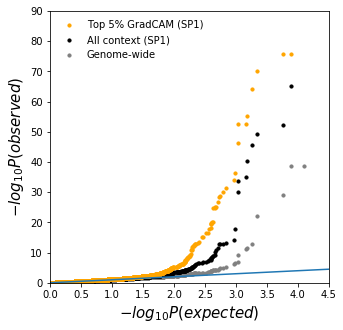

In [10]:
for f in factors:
    if f != "SP1":
        continue
    high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[0]]
    high_scored_ab_ext = gwd[f][gwd[f]["rank"] >= rank_perc[1]]

    # control - same MA_FREA distribution
    dist, _ = numpy.histogram(high_scored_ab["MA_FREQ"].tolist(), bins=bins)
    control_list = []
    control_list_all = []
    for bin_index in range(len(bins)-1):
        lower, upper = bins[bin_index], bins[bin_index + 1]
        n_samples = dist[bin_index]
        control_list.append((gwd[f][(gwd[f]["MA_FREQ"] >= lower) & (gwd[f]["MA_FREQ"] < upper)]).sample(n_samples))
        control_list_all.append((gwas[(gwas["MA_FREQ"] >= lower) & (gwas["MA_FREQ"] < upper)]).sample(n_samples))
    control = pd.concat(control_list)
    control_all = pd.concat(control_list_all)
        
    s_high_scored_ab = high_scored_ab["MLOG10P"]
    s_high_scored_ab_ext = high_scored_ab_ext["MLOG10P"]
    s_ct = control["MLOG10P"]
    s_ct_all = control_all["MLOG10P"]

    s_random = [-log10(random.random()) for _ in range(high_scored_ab.shape[0])]
    s_random_ext = s_random[:high_scored_ab_ext.shape[0]]
        
    y_points_ab = sorted(s_high_scored_ab.values.tolist())
    y_points_ab_ext = sorted(s_high_scored_ab_ext.values.tolist())
    y_points_ct = sorted(s_ct.values.tolist())
    y_points_ct_all = sorted(s_ct_all.values.tolist())
    x_points = sorted(s_random)
    x_points_ext = sorted(s_random_ext)
        
    fig = plt.figure()
    fig.set_size_inches((5, 5))
    ax = fig.add_subplot(111)
    line_ct_all = ax.scatter(x_points, y_points_ct_all, c="grey", s=10)
    line_ct = ax.scatter(x_points, y_points_ct, c="k", s=10)
    line_ab = ax.scatter(x_points, y_points_ab, c="orange", s=10)
    #ax.scatter(x_points_ext, y_points_ab_ext, c="red", s=10)
    ax.set_xlabel("$-log_{10} P (expected)$", size=15)
    ax.set_ylabel("$-log_{10} P (observed)$", size=15)
    ((xmin,xmax), (ymin,ymax)) = ((0, 4.5), (0, 90))
    ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.legend([line_ab, line_ct, line_ct_all],
              ["Top 5% GradCAM (SP1)", "All context (SP1)", "Genome-wide"],
              loc="upper left", frameon=False)
    fig.savefig("gwas_SP1_wbc.pdf")

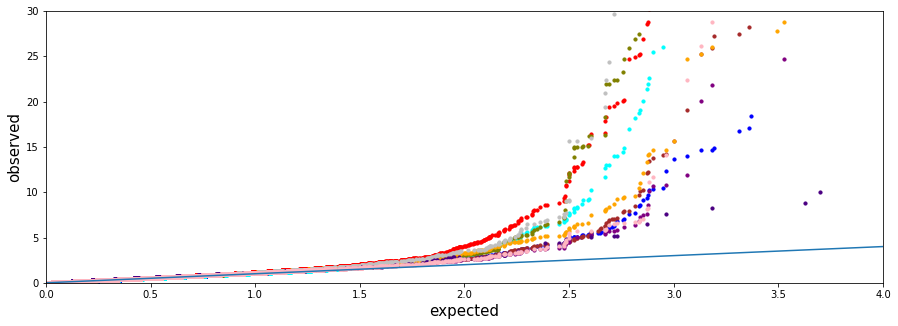

In [11]:
factors_to_plot = ["SP1", "EBF1", "PU1", "RUNX3", "NFYB", "Nrf1", "ELF1", "NFKB", "Znf143", "TCF3"]
f2c = {"SP1": "r", "EBF1":"b", "PU1":"brown", "RUNX3":"cyan",
       "NFYB":"olive", "Nrf1":"purple", "ELF1":"orange",
       "NFKB":"silver", "Znf143":"indigo", "TCF3":"lightpink"}

for perc_index in [0]:
    fig = plt.figure()
    fig.set_size_inches((15, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel("expected", size=15)
    ax.set_ylabel("observed", size=15)
    ((xmin,xmax), (ymin,ymax)) = ((0, 4), (0, 30))
    ax.add_line(matplotlib.lines.Line2D([ymin,ymax], [ymin,ymax]))
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    s_random = [-log10(random.random()) for _ in range(int(10e6))]
    for f in factors_to_plot:
        high_scored_ab = gwd[f][gwd[f]["rank"] >= rank_perc[perc_index]]
        s_high_scored_ab = high_scored_ab["MLOG10P"]
        y_points_ab = sorted(s_high_scored_ab.values.tolist())        
        x_points = sorted(s_random[:high_scored_ab.shape[0]])
        
        ax.scatter(x_points, y_points_ab, c=f2c[f], s=10)